# Jeux Olympique analyses

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

## Etude des données

Il s'agit d'un ensemble de données historiques sur les Jeux olympiques modernes, comprenant tous les Jeux d'Athènes 1896 à Rio 2016. Ces données ont été éxtraite à partir de www.sports-reference.com en mai 2018.


Notez que les Jeux d'hiver et d'été ont eu lieu la même année jusqu'en 1992. Après cela, ils ont été échelonnés de telle sorte que les Jeux d'hiver ont lieu sur un cycle de quatre ans à partir de 1994, puis les Jeux d'été en 1996, puis les Jeux d'hiver en 1998, et ainsi de suite. 

### Valeurs manquantes

In [ ]:
df_events = pd.read_csv("athlete_events.csv", index_col='ID')
number_index = df_events.index.size
print(f'Il y à {number_index} entrés.')
df_events.head()

Il y à 271116 entrés.


,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
ID,,,,,,,,,,,,,,
1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


Nous regardons si des données sont manquantes. Nous pouvons noter qu'il y a des valeurs manquantes sur ces colonnes.
   - Âge (9474 valeurs manquantes)
   - Height (60171 valeurs manquantes)
   - Weight (62875 valeurs manquantes)
   - Medal (231333 valeurs manquantes !)
   
Vue que nous avons énormement de lignes concernants `Medals` il n'est pas envisagable de les supprimer, cependant, nous pouvons le faire pour les trois autres.

In [ ]:
df_events.isnull().sum()

Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64

In [ ]:
df_events.dropna(inplace=True, subset=['Age', 'Height', 'Weight'])
df_events.isnull().sum()

Name           0
Sex            0
Age            0
Height         0
Weight         0
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     175984
dtype: int64

In [ ]:
print(f'Il y à maintenant {df_events.index.size} entrés et nous avons perdu {100-(df_events.index.size*100)/number_index}% des données cela reste respectable pour faire des analyse dessus.')

Il y à maintenant 206165 entrés et nous avons perdu 23.956904055828502% des données cela reste respectable pour faire des analyse dessus.


### Recherchons si nous avons des valeurs abérantes et expliquons les

Il y a 3 principales valeurs à vérifier. L'âge, la taille et le poids.

L'**âge** va de 11 à 71 ans, ce qui semble être cohérant. Un enfant et une personne agée peuvent participer aux JO sans problème.

La **taille** va de 127 à 226 cm représentant des personnes de petite taille et d'autres de grande. Les grandes tailles peuvent s'expliquer aux prédispositions de chaque sport.

De même pour le **poids** allant de 70 à 214 kg.

In [ ]:
df_events[['Age', 'Height', 'Weight']].describe()

,Age,Height,Weight
count,206165.000000,206165.000000,206165.000000
mean,25.055509,175.371950,70.688337
std,5.483096,10.546088,14.340338
min,11.000000,127.000000,25.000000
25%,21.000000,168.000000,60.000000
50%,24.000000,175.000000,70.000000
75%,28.000000,183.000000,79.000000
max,71.000000,226.000000,214.000000


### Fouiller les données pour voir ce qu'on peut en faire

<ins>Nombre d'athlètes par sexe</ins>

En regardant le pourcentage d'hommes et de femmes qui ont participé aux jeux olympiques, on peut voir qu'il y a plus d'hommes que de femmes dans la compétition, tous sports confondus.

In [ ]:
df_events['Sex'].value_counts(normalize=True) * 100

M    67.641937
F    32.358063
Name: Sex, dtype: float64

<ins>Caractéristiques physiques</ins>

En faisant une moyenne sur les caracteristiques physiques des sportives des hommes et des femmes qui ont participé aux jeux olympiques, on peut noter que les femmes sont globalement plus jeunes, plus petites et moins lourdes que les hommes.

In [ ]:
df_events[['Sex', 'Age', 'Height', 'Weight']].groupby(['Sex']).mean()

,Age,Height,Weight
Sex,,,
F,23.779467,167.861312,60.022575
M,25.665933,178.964834,75.790547


<ins>Nombre de médailles par sexe</ins>

Les femmes ont deux fois moins de médailles que les hommes. Cela peut s'expliquer par le nombre d'athlètes féminines inférieur à celui des hommes et également par le nombre d'épreuves différentes selon le sexe.

In [ ]:
df_events[['Sex', 'Medal']].groupby('Sex').count()

,Medal
Sex,
F,10350
M,19831


<ins>Nombre de médailles gagnées en fonction du sexe</ins>

Lors des débuts des Jeux Olympiques, les femmes ne gagnaient pas de médailles et il n'y avait pas beaucoup de sports aux Jeux Olympiques. En 2016, il y plus de sports et les femmes ont autant de médailles que les hommes.

In [ ]:
df_events[['Year', 'Sex', 'Medal']].groupby(['Year', 'Sex']).count()

Medal
Year Sex       
1896 M       20
1900 M       38
1904 M       59
1906 M       69
1908 M      134
...         ...
2012 M     1014
2014 F      250
     M      320
2016 F      967
     M     1047

[64 rows x 1 columns]

<ins>Réprésentation de l'âge des sportifs</ins>

Les femmes sont un peu plus jeunes que les hommes et deux fois moins nombreuses.

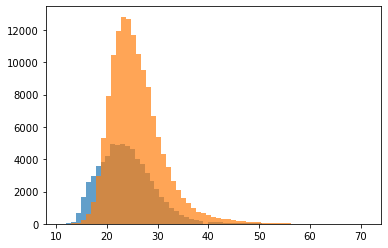

In [ ]:
grouped = df_events.groupby('Sex')
for group in grouped:
  plt.hist(group[1].Age, bins=60,  alpha=.7)

<ins>Nombre total de médailles par pays</ins>

In [ ]:
df_events[['NOC', 'Medal']].groupby('NOC').count()

,Medal
NOC,
AFG,2
AHO,0
ALB,0
ALG,15
AND,0
...,...
YEM,0
YMD,0
YUG,321


In [ ]:
df_events[['NOC', 'Medal']].groupby('NOC').count().describe()

,Medal
count,226.000000
mean,133.544248
std,410.279861
min,0.000000
25%,0.000000
50%,2.000000
75%,46.250000
max,4383.000000


<ins>Le sport avec le plus de médailles</ins>

In [ ]:
df2 = df_events.groupby('Sport').count()
df2['Medal'].idxmax()

'Athletics'

<ins>Les athlètes ayant gagnés une médaille d'or</ins>

In [ ]:
df_events[df_events['Medal'] == "Gold"]

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
ID,,,,,,,,,,,,,,
17,Paavo Johannes Aaltonen,M,28.0,175.0,64.0,Finland,FIN,1948 Summer,1948,Summer,London,Gymnastics,Gymnastics Men's Team All-Around,Gold
17,Paavo Johannes Aaltonen,M,28.0,175.0,64.0,Finland,FIN,1948 Summer,1948,Summer,London,Gymnastics,Gymnastics Men's Horse Vault,Gold
17,Paavo Johannes Aaltonen,M,28.0,175.0,64.0,Finland,FIN,1948 Summer,1948,Summer,London,Gymnastics,Gymnastics Men's Pommelled Horse,Gold
20,Kjetil Andr Aamodt,M,20.0,176.0,85.0,Norway,NOR,1992 Winter,1992,Winter,Albertville,Alpine Skiing,Alpine Skiing Men's Super G,Gold
20,Kjetil Andr Aamodt,M,30.0,176.0,85.0,Norway,NOR,2002 Winter,2002,Winter,Salt Lake City,Alpine Skiing,Alpine Skiing Men's Super G,Gold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135503,Zurab Zviadauri,M,23.0,182.0,90.0,Georgia,GEO,2004 Summer,2004,Summer,Athina,Judo,Judo Men's Middleweight,Gold
135520,Julia Zwehl,F,28.0,167.0,60.0,Germany,GER,2004 Summer,2004,Summer,Athina,Hockey,Hockey Women's Hockey,Gold
135523,"Ronald Ferdinand ""Ron"" Zwerver",M,29.0,200.0,93.0,Netherlands,NED,1996 Summer,1996,Summer,Atlanta,Volleyball,Volleyball Men's Volleyball,Gold


<ins>Les médianes de la taille et du poids</ins>

In [ ]:
df_events[['Height', 'Weight']].median()

Height    175.0
Weight     70.0
dtype: float64

<ins>Nombre de médailles par sexe depuis 1900</ins>

On peut observer plusieurs choses :
 - de 1900 à 1950, il n'y a pas beaucoup de sports
 - les femmes ont moins de médailles
 - En 1990, les jeux olympique d'hiver apparaissent (A prendre en compte lors de l'apprentisage)

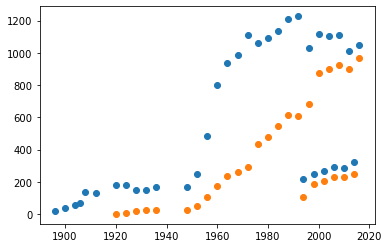

In [ ]:
dfH = df_events[(df_events['Medal'] != "No Medal") & (df_events['Sex'] == "M")][['Year', 'Medal']]
dfH = dfH.groupby(['Year']).count()

dfF = df_events[(df_events['Medal'] != "No Medal") & (df_events['Sex'] == "F")][['Year', 'Medal']]
dfF = dfF.groupby(['Year']).count()

plt.scatter(dfH.index, dfH['Medal'])
plt.scatter(dfF.index, dfF['Medal'])
plt.show()

### Cherche a taton n'est pas très productif voyons du coté des outils général

Sur cette vue on peux remarque que il y a de plus en plus de femme qui partisipe au jeux olympique.

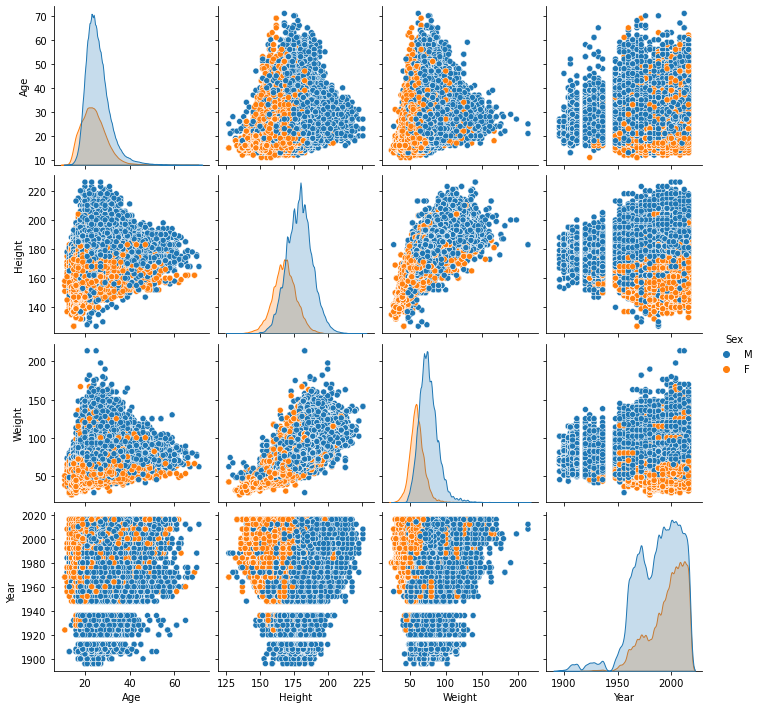

In [ ]:
sns.pairplot(df_events, hue = 'Sex')
plt.show()

De plus, avec la matrice de correlation on remarque la taille a une bonne relation avec le poids. Ce qui peux s'expliquer par une bonne condition physique.

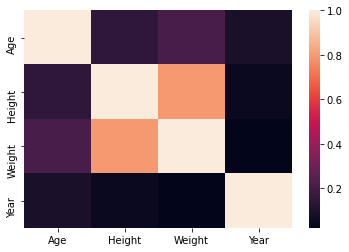

In [ ]:
sns.heatmap(df_events.corr())
plt.show()

On remarque même une tendance linéaire entre la taille et le poids avec quelque valeur abérente au extraimités ce qui pourrais perturber l'apprentisage du future model. on remarque même quelque valeurs abérente sur l'age.

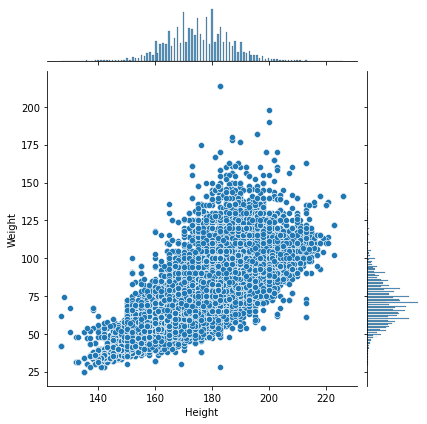

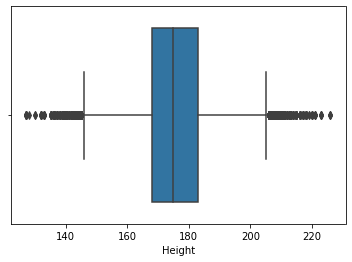

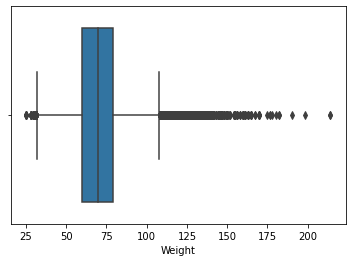

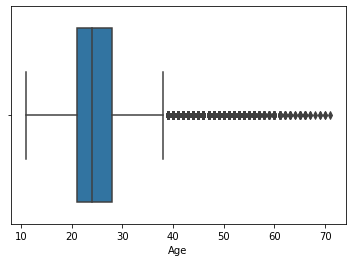

In [ ]:
sns.jointplot(data=df_events, x="Height", y="Weight")
plt.show()
sns.boxplot(data=df_events, x="Height")
plt.show()
sns.boxplot(data=df_events, x="Weight")
plt.show()
sns.boxplot(data=df_events, x="Age")
plt.show()

## Apprentisage supervisé

### Thématique

Prédire avec la **taille**, le **poids**, l'**age** le **sport** de prédilection d'un sportif

### Préparons notre dataset

Tout dabor avant de commencer sur le model il faut préparer les données. Il y a beaucoup de données textuel qui représente des classes. Comme vue dans la partie étude des données, il faut nétoiyer le dataset pour enlever tout les abération, valeur manquante et unitile. Pour cela nous alons filtré les colones, supprimer les ligne ou il manque la taille, poid et l'age aves `dropna`. De plus, nous allons encode les classification avec `LabelEncoder`.


In [ ]:
df_events = pd.read_csv("athlete_events.csv")                                   # Charge le dataset

df_events.dropna(inplace=True, subset=['Age', 'Height', 'Weight'])            # Enleve les ligne altéré
df_events = df_events[['Sex', 'Age', 'Height', 'Weight', 'Team', 'Sport']]    # Garde les cololones utiles

df_events = df_events[(df_events['Age'] < 85) & (df_events['Weight'] < 200)]  # Filtre les abération pour l'age et le poids

label_encoder_team = LabelEncoder()
df_events['Team'] = label_encoder_team.fit_transform(df_events['Team'])         # Transforme les Teams en nombres
label_encoder_sport = LabelEncoder()
df_events['Sport'] = label_encoder_sport.fit_transform(df_events['Sport'])      # Transforme les Sports en nombres
label_encoder_sex = LabelEncoder()
df_events['Sex'] = label_encoder_sex.fit_transform(df_events['Sex'])            # Transforme les Sex en nombres

df_events.head()

,Sex,Age,Height,Weight,Team,Sport
0,1,24.0,180.0,80.0,114,6
1,1,23.0,170.0,60.0,114,26
4,0,21.0,185.0,82.0,374,43
5,0,21.0,185.0,82.0,374,43
6,0,25.0,185.0,82.0,374,43


On peux voir ici qu'il y a une forte correlation entre le traille et le poids. De plus, on remarque aussi une petite correlation avec le sex, la taille et le poids. On peux faire le raprochement avec la condition physique des femmes et des hommes qui diffère.

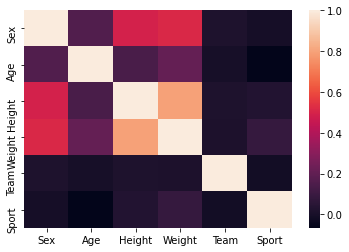

In [ ]:
sns.heatmap(df_events.corr())
plt.show()

Ici on va prépares deux jeux de donnée le premier pour entrainer le model et le second pour test si notre model a bien appris.

In [ ]:
Y = df_events['Sport']
X = df_events.drop('Sport', axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True, train_size=0.8, random_state=42)

### Premier model KNeighborsClassifier

Nous avons choisis pour premier le KNeighborsClassifier. Nous l'avons choisis car son fonctionnement est assez simple, K Nearest Neighbor (KNN) est un algorithme d'apprentissage automatique très simple, facile à comprendre, polyvalent et l'un des plus importants utiliser pour des problèmes de classification et de régression qui est basé sur une approche de similarité des caractéristiques.

In [ ]:
model_kn1 = KNeighborsClassifier(n_neighbors=1)
model_kn1.fit(X_train, Y_train)
print(model_kn1.score(X_train, Y_train))
accuracy = accuracy_score(Y_test,model_kn1.predict(X_test))
print('Accuracy (%): ', accuracy * 100)
print(classification_report(Y_test,model_kn1.predict(X_test)))

0.9415752137270357
Accuracy (%):  50.90340261441079
              precision    recall  f1-score   support

           0       0.65      0.73      0.69      1272
           1       0.46      0.53      0.49       359
           2       0.60      0.60      0.60         5
           3       0.55      0.54      0.54      6531
           4       0.32      0.26      0.29       276
           5       0.16      0.14      0.15       177
           6       0.34      0.29      0.32       741
           7       0.22      0.15      0.18        91
           8       0.68      0.80      0.73       950
           9       0.59      0.52      0.55       425
          10       0.20      0.15      0.17       859
          11       0.38      0.40      0.39      1129
          12       0.68      0.83      0.75      1502
          13       0.02      0.01      0.01        84
          14       0.41      0.43      0.42      1519
          15       0.38      0.38      0.38       397
          16       0.62      

Dans un premier temps nous avons désider de mettre l'hyperparametre n_neighbors a 1 et nous avons trouver un score de 94.12 ! Nous nous somme dis que la valeur était trop haute pour un premier apprentisage et apres plusieurs recherche sur google il est de bonne pratique de prendre la racine du nombre de colone du dataset soit $\sqrt{6}\approx2$. De plus, on remarque que la précision dans le test set drop enormement.

In [ ]:
model_kn2 = KNeighborsClassifier(n_neighbors=2)
model_kn2.fit(X_train, Y_train)
model_kn2.score(X_train, Y_train)

0.7385739404595889

Nous avons obtenue un score de 0.73 pour un premier apprentisage ce 
n'est pas si mal que ca. Cependant nous avons besoins de plus d'information sur la précision du model pour cela nous utiliserons `accuracy` et `classification_report` pour nous aider e jugé si le model est correcte ou non.

Nous avons une précision de 44.21% et nous pouvons voir que les prédiction son assez hasardeuses. Pour palier a cela nous avons plusieurs options.
 - Change de model
 - Classifier des données (Age, Team, Sport)
 - Normalisation des données 
 
Nous n'allons pas normaliser les données car cela ne va pas forcement aide nos models. Cependant nous allons crée des catégories sur plusieurs colones différent.

In [ ]:
accuracy = accuracy_score(Y_test,model_kn2.predict(X_test))
print('Accuracy (%): ', accuracy * 100)
print(classification_report(Y_test,model_kn2.predict(X_test)))

Accuracy (%):  44.21458540489414
              precision    recall  f1-score   support

           0       0.48      0.79      0.60      1272
           1       0.32      0.58      0.41       359
           2       0.36      0.80      0.50         5
           3       0.44      0.63      0.52      6531
           4       0.23      0.32      0.27       276
           5       0.13      0.21      0.16       177
           6       0.28      0.35      0.31       741
           7       0.19      0.21      0.20        91
           8       0.54      0.78      0.64       950
           9       0.44      0.49      0.46       425
          10       0.14      0.14      0.14       859
          11       0.27      0.38      0.31      1129
          12       0.57      0.76      0.65      1502
          13       0.02      0.02      0.02        84
          14       0.29      0.35      0.32      1519
          15       0.25      0.26      0.25       397
          16       0.48      0.57      0.52     

### Deuxieme model AdaBoostClassifier

Nous avons pris un autre model de classification `AdaBoostClassifier` avec le même dataset pour comparer les performances. Les résultat son très désevant. Le model n'arrive pas a prédire les différent sport comme le montre la précision des différente classe a 0%.

In [ ]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, Y_train)
clf.score(X_train,Y_train)

accuracy = accuracy_score(Y_test,clf.predict(X_test))

print('Accuracy (%): ', accuracy * 100)
print(classification_report(Y_test,clf.predict(X_test)))

Accuracy (%):  18.32270268959329
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1272
           1       0.00      0.00      0.00       359
           2       0.00      0.00      0.00         5
           3       0.16      0.78      0.27      6531
           4       0.00      0.00      0.00       276
           5       0.00      0.00      0.00       177
           6       0.00      0.00      0.00       741
           7       0.00      0.00      0.00        91
           8       0.00      0.00      0.00       950
           9       0.00      0.00      0.00       425
          10       0.00      0.00      0.00       859
          11       0.00      0.00      0.00      1129
          12       0.00      0.00      0.00      1502
          13       0.00      0.00      0.00        84
          14       0.00      0.00      0.00      1519
          15       0.00      0.00      0.00       397
          16       0.29      0.06      0.10     

C:\Users\irles\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\irles\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Modification du dataset pour KNeighborsClassifier

Nous avons modifer le dataset avec le premier model vue qu'il fonctionne plus ou moins biens. Nous avons donc fait le filtrage habituel mais nous avons utiliser l'encodage oneHot sur toutes les catégorie du dataset. Cependant, le model est beaucoup moins précis. Cela est sans doute due au nombre exesif de colone produite pas le oneHot. Soit autant de colone qu'il y a de pays et de sport.

In [ ]:
df_events = pd.read_csv("athlete_events.csv")                                 # Charge le dataset

df_events.dropna(inplace=True, subset=['Age', 'Height', 'Weight'])            # Enleve les ligne useless
df_events = df_events[['Sex', 'Age', 'Height', 'Weight', 'Team', 'Sport']]    # Garde les cololones utiles

df_events = df_events[(df_events['Age'] < 85) & (df_events['Weight'] < 200)]  # Filtre les abération pour l'age et le poids

def cat_age(age):
    if 0 < age < 18: return "jeune"
    if 18 < age < 30: return "normal"
    return "vieux"

df_events['Age'] = df_events['Age'].apply(cat_age)                 # Catégorise l'age en 3 classe
df_2_X = pd.get_dummies(df_events,columns=['Sex', 'Age', 'Team'])  # Encode le Sex, Age, Team en OneHot
df_2_X = df_2_X.drop(['Sport'], axis=1)

df_2_Y = pd.get_dummies(df_events[['Sport']],columns=['Sport'])

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df_2_X, df_2_Y, shuffle=True, train_size=0.8, random_state=42)

model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train, Y_train)
model.score(X_train, Y_train)

0.4783120111562481

In [ ]:
accuracy = accuracy_score(Y_test,model.predict(X_test))

print('Accuracy (%): ', accuracy * 100)
print(classification_report(Y_test,model.predict(X_test)))

Accuracy (%):  31.355952756287444
              precision    recall  f1-score   support

           0       0.74      0.44      0.56      1272
           1       0.57      0.23      0.33       359
           2       1.00      0.20      0.33         5
           3       0.70      0.32      0.44      6531
           4       0.60      0.08      0.14       276
           5       0.43      0.05      0.09       177
           6       0.73      0.24      0.36       741
           7       0.80      0.04      0.08        91
           8       0.72      0.49      0.58       950
           9       0.78      0.24      0.36       425
          10       0.62      0.12      0.20       859
          11       0.57      0.19      0.29      1129
          12       0.71      0.45      0.55      1502
          13       0.20      0.01      0.02        84
          14       0.56      0.18      0.28      1519
          15       0.62      0.16      0.26       397
          16       0.65      0.36      0.46    

C:\Users\irles\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\irles\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\irles\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Random Forset et moins de paramètre

Nous avons changer de model en utilisant les randoms forests pour minimiser la variance. Nous avons supprimer les ligne ou il y a des valeur manquante sur les colones Age, Height et Weight et filtrer les colones utiles ainsi que déléminer les valeurs abérante.

Nous avons encoder la colone Team avec des nombre car cela fesait trop de colones avec un encodage oneHot et nous avons encoder l'age et le sex avec onehot.

Ensuite, nous avons généré les trainset et le testset, puis entrainer le model et nous avons enfin passer la barre des 80% de précision ! Cepandant, quand on regarde le rapport de classification nous pouvons remarquer qu'il y a quelque incohenrence sur la précision et le recall.

Pour palier à cela nous allons classifier les différent sport pour avoir moins de classe a prédire et pour aider le model a ce consentré sur celle ci.

In [3]:
df_events = pd.read_csv("athlete_events.csv")                                 # Charge le dataset

df_events.dropna(inplace=True, subset=['Age', 'Height', 'Weight'])            # Enleve les ligne useless
df_events = df_events[['Sex', 'Age', 'Height', 'Weight', 'Team', 'Sport']]    # Garde les cololones utiles

df_events = df_events[(df_events['Age'] < 85) & (df_events['Weight'] < 200)]  # Filtre les abération pour l'age et le poids

label_encoder_team = LabelEncoder()
df_events['Team'] = label_encoder_team.fit_transform(df_events['Team'])
label_encoder_sport = LabelEncoder()
df_events['Sport'] = label_encoder_sport.fit_transform(df_events['Sport'])
label_encoder_sex = LabelEncoder()
df_events['Sex'] = label_encoder_sex.fit_transform(df_events['Sex'])

def cat_age(age):
    if 0 < age < 18: return "jeune"
    if 18 < age < 30: return "normal"
    return "vieux"

df_events['Age'] = df_events['Age'].apply(cat_age)

Y = df_events['Sport']
X = pd.get_dummies(df_events,columns=['Sex', 'Age'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True, train_size=0.8, random_state=42)
X.head()

,Height,Weight,Team,Sport,Sex_0,Sex_1,Age_jeune,Age_normal,Age_vieux
0,180.0,80.0,114,6,0,1,0,1,0
1,170.0,60.0,114,26,0,1,0,1,0
4,185.0,82.0,374,43,1,0,0,1,0
5,185.0,82.0,374,43,1,0,0,1,0
6,185.0,82.0,374,43,1,0,0,1,0


In [ ]:
classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
classifier.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [ ]:
predicted_classes = classifier.predict(X_test)
accuracy = accuracy_score(Y_test,predicted_classes)

print('Accuracy (%): ', accuracy * 100)
print(classification_report(Y_test,predicted_classes))

Accuracy (%):  84.44934882254505
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1272
           1       1.00      1.00      1.00       359
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00      6531
           4       1.00      0.01      0.03       276
           5       1.00      0.01      0.02       177
           6       0.81      0.79      0.80       741
           7       0.83      0.05      0.10        91
           8       0.76      0.75      0.76       950
           9       0.70      0.61      0.66       425
          10       0.78      0.68      0.73       859
          11       0.63      0.89      0.74      1129
          12       0.85      0.98      0.91      1502
          13       1.00      0.01      0.02        84
          14       0.96      0.99      0.97      1519
          15       0.71      0.34      0.46       397
          16       0.70      0.68      0.69     

C:\Users\irles\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Chagement de thématique

Nous avons décider de changer de thématique pour facilier de travail du model a classifier les différents sport tout en gardant un rapport avec la précedante problématique.

~Prédire avec la **taille**, le **poids**, l'**age** le **sport** de prédilection d'un sportif.~

Prédire avec la **taille**, le **poids**, l'**age** le **type de sport (groupe ou individuel)** d'un sportif.

Pour classifier les sport nous avons recupé touts les sports du dataframe et enlever les doublons, ensuite nous avons transformer cette liste en un disctionnaire assosiatif. Deplus, on a enlever l'encodage de l'age car cela ne fesait aucune différence. Il conviens que ce n'est qu'une solution temporaire, nous avons concience que il ce peux que des sport soit supprimer ou ajouter au file du temps.

 - 0: sport individuel
 - 1: sport de groupe

In [4]:
df_events = pd.read_csv("athlete_events.csv")                               # Charge le dataset
sports = df_events.Sport.values.tolist()                                    # get sport value
sports = list(dict.fromkeys(sports))                                        # delete doublons 
sport_dictionary = dict.fromkeys(sports, 0)                                 # tranform to dict

def sport_to_group(sport):
    return {
     'Basketball': 1,
     'Judo': 0,
     'Football': 1,
     'Tug-Of-War': 1,
     'Speed Skating': 0,
     'Cross Country Skiing': 0,
     'Athletics': 0,
     'Ice Hockey': 1,
     'Swimming': 0,
     'Badminton': 0,
     'Sailing': 1,
     'Biathlon': 0,
     'Gymnastics': 0,
     'Art Competitions': 0,
     'Alpine Skiing': 0,
     'Handball': 1,
     'Weightlifting': 0,
     'Wrestling': 0,
     'Luge': 0,
     'Water Polo': 1,
     'Hockey': 1,
     'Rowing': 1,
     'Bobsleigh': 1,
     'Fencing': 0,
     'Equestrianism': 0,
     'Shooting': 0,
     'Boxing': 0,
     'Taekwondo': 0,
     'Cycling': 0,
     'Diving': 0,
     'Canoeing': 0,
     'Tennis': 0,
     'Modern Pentathlon': 0,
     'Figure Skating': 0,
     'Golf': 0,
     'Softball': 1,
     'Archery': 0,
     'Volleyball': 1,
     'Synchronized Swimming': 1,
     'Table Tennis': 0,
     'Nordic Combined': 0,
     'Baseball': 1,
     'Rhythmic Gymnastics': 0,
     'Freestyle Skiing': 0,
     'Rugby Sevens': 1,
     'Trampolining': 0,
     'Beach Volleyball': 1,
     'Triathlon': 0,
     'Ski Jumping': 0,
     'Curling': 1,
     'Snowboarding': 0,
     'Rugby': 1,
     'Short Track Speed Skating': 0,
     'Skeleton': 0,
     'Lacrosse': 1,
     'Polo': 1,
     'Cricket': 1,
     'Racquets': 0,
     'Motorboating': 0,
     'Military Ski Patrol': 0,
     'Croquet': 0,
     'Jeu De Paume': 0,
     'Roque': 0,
     'Alpinism': 0,
     'Basque Pelota': 1,
     'Aeronautics': 0
    }[sport]

Reprenon le code de la randomForset avec notre nouvelle colone sport. Nous avons aussi enlever l'encodage oneHot pour l'age et le sex car cela n'avais pas grand impact sur le resultat. Dans le rapport de classification nous pouvons observer que :

#### classe 0
 - Quand on prédit une valeur elle a 83% d'être bien prédit
 - Quand on prédit une valeur elle a 97% d'etre dans la bonne classe
 
#### classe 1
 - Quand on prédit une valeur elle a 70% d'être bien prédit
 - Quand on prédit une valeur elle a 260% d'etre dans la bonne classe
 
Il faut nuancer les resultats de la classe 1 car il y a un écart non négligeable avec le support. Pour resoudre ce déséquilibre nous pouvons soit rajouter des élément dans la casse 1 (crée des nouveaux vecteur) ou supprimer des vecteurs dans la classe 0. Dans l'état actuel non n'allons toucher a rien et utiliser un model plus performant avec xgboost qui va reduire la variance. 

In [5]:
df_events = pd.read_csv("athlete_events.csv")                               # Charge le dataset
df_events.dropna(inplace=True, subset=['Age', 'Height', 'Weight'])          # Enleve les ligne useless
df_events = df_events[['Sex', 'Age', 'Height', 'Weight', 'Team', 'Sport']]  # Garde les cololones utiles

label_encoder_team = LabelEncoder()
df_events['Team'] = label_encoder_team.fit_transform(df_events['Team'])
label_encoder_sex = LabelEncoder()
df_events['Sex'] = label_encoder_sex.fit_transform(df_events['Sex'])

df_events['Sport'] = df_events['Sport'].apply(sport_to_group)

Y = df_events['Sport']
X = df_events[["Age", "Weight", "Height", "Team", "Sex"]]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True, train_size=0.8, random_state=42)
X_train

,Age,Weight,Height,Team,Sex
144064,21.0,57.0,170.0,398,1
9494,23.0,82.0,186.0,529,1
142664,38.0,85.0,173.0,210,1
81949,30.0,58.0,177.0,342,0
120202,18.0,58.0,169.0,245,0
...,...,...,...,...,...
158533,21.0,62.0,174.0,143,0
137333,17.0,57.0,165.0,193,0
174172,23.0,63.0,175.0,398,0
193714,27.0,71.0,175.0,531,1


In [6]:
classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
classifier.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [7]:
predicted_classes = classifier.predict(X_test)
accuracy = accuracy_score(Y_test,predicted_classes)

print('Accuracy (%): ', accuracy * 100)
print(classification_report(Y_test,predicted_classes))

Accuracy (%):  81.71367593917493
              precision    recall  f1-score   support

           0       0.83      0.97      0.89     32390
           1       0.70      0.26      0.37      8843

    accuracy                           0.82     41233
   macro avg       0.76      0.61      0.63     41233
weighted avg       0.80      0.82      0.78     41233



Nous venons de tester le model RandomForset qui a pour but de minimuser la variance. Maintenant, nous allons voir ce que ca donne avec xgBoost qui va minimiser la variance avec pleins de model faile et reduire le biais.

In [8]:
param = {
    'max_depth':4, 
    'eta':0.2, 
    'objective':'binary:logistic',
    'n_estimators': 250,
    'learning_rate': 0.05,
    'gamma': 0.1
}
booster = xgb.XGBClassifier(**param)
booster.fit(X_train, Y_train)
print(booster.score(X_train, Y_train))

0.8172701476972328


In [9]:
predicted_classes = booster.predict(X_test)
accuracy = accuracy_score(Y_test,predicted_classes)

print('Accuracy (%): ', accuracy * 100)
print(classification_report(Y_test,predicted_classes))

Accuracy (%):  81.83736327698688
              precision    recall  f1-score   support

           0       0.83      0.97      0.89     32390
           1       0.70      0.26      0.38      8843

    accuracy                           0.82     41233
   macro avg       0.77      0.62      0.64     41233
weighted avg       0.80      0.82      0.78     41233



Maintenant que nous avons trouvé un meilleur model qui ce focalise sur la reduction du biais. Nous allons ensuite cherche les bons hyperparametre de notre model et verifier avec la cross validation si notre model est robuste.

Nous allons trouvé les bon hyperparametre a l'aide de `GridSearchCV` et de vérifier si notre modele est robuste gace a `cross_val_score` avec la métrique précision.


In [13]:
param_grid = {
  'max_depth':[2, 3, 4], 
  'eta': [0.1, 0.2, 0.3], 
  'objective':['binary:logistic'],
  'n_estimators': [100, 200, 300],
  'learning_rate': [0.1, 0.05],
  'gamma': [0.1]
}

grid = GridSearchCV(xgb.XGBClassifier(), param_grid, cv=5)
grid.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'eta': [0.1, 0.2, 0.3], 'gamma': [0.1],
                         'learning_rate': [0.1, 0.05], 'max_depth': [2, 3, 4],
                         'n_estim

In [16]:
print(grid.best_params_)
model = grid.best_estimator_

{'eta': 0.1, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300, 'objective': 'binary:logistic'}


Avec cette optimisation nous avons gagner 1% de précision.

In [ ]:
predicted_classes = model.predict(X_test)
accuracy = accuracy_score(Y_test,predicted_classes)

print('Accuracy (%): ', accuracy * 100)
print(classification_report(Y_test,predicted_classes))

Accuracy (%):  82.30543496713797
              precision    recall  f1-score   support

           0       0.83      0.97      0.90     32390
           1       0.71      0.30      0.42      8843

    accuracy                           0.82     41233
   macro avg       0.77      0.63      0.66     41233
weighted avg       0.81      0.82      0.79     41233



### Cross validation des données

Nous pouvons remarque nous obtenons la même précision qu'avec notre test set notre model est donc bien robuste !

In [17]:
scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='accuracy')
scores.mean()

0.821811419288253

## Contrendu de l'édude "Historique olympique"

### Quelle problématique globale avez-vous identifié/choisi ?

Nous avons dabord choisis de **prédire avec la taille, le poids, l'age et le sex le sport de prédilection d'un sportif** puis nous avons changé pour **prédire si le sportif etait fait pour joué en groupe ou individielement**.

### Quels problèmes avez-vous rencontré avec les données ? Quelles explorations en conséquence ?

Premièrement nous avons voulus supprimer tous les vecteurs qui avait un NaN dans leurs colone. Cependant nous n'avons pas enlever les vecteurs sans medal car nous perdon beaucoup trop d'information. Nous avons donc supprimer les NaN des vecteurs ayant pour colone l'age, la taille, le poids.

Nous avons eu aussi du mal trouvé les bonnes encodage pour certaine colones pour au final n'encoder que le sex. Nous avons tenter d'encoder l'age avec oneHot mais cela de changais pas les performance de notre model. De plus, nous avons aussi tanté l'encodage oneHote de les teams et les sport mais cela a eu pour effect de crée des tonnes de colone et a réduit drastiquement les performance de nos model.

Dans nos observation nous avons pas pu établir de correlation avec le type de sport et les autres attribut mais nous avons remarquer que la taille et le poids était liée.

### Quel(s) modèle(s) avez-vous choisi ? Pourquoi ?

Nous avons somme dabord partis un model KNeighborsClassifier car c'est un model simple a comprend pour un début. Nous avons remarquer un sur apprentisage car il y avec un drop de performance entre le train et le test. Nous avons donc change hyperparametre des voisins en fonction du nombre de colones pour que le model ce comporte correctement sans succes.

Pour palier a cela nous avons choisis un autre model AdaBoostClassifier sans succes. Nous avons donc choisis d'utiliser le RandomForestClassifier pour minimiser la variance, nous avons aussi reduire le nombre de colone suite a l'encodage one hot. En effect, nous avons remarque que cela augmentais le temps de calcule et besais la performance des models.

Suite aux bonne performance de ce genre de model nous avons utiliser un autre type de model utilisant les arbre, xgBoost qui lui travail sur la reduction du biais. Avec le même dataset que pour les random forest nous avons gagner 1% et avec les optimisation nosu avons aussi gagner 1%. Soit un gain de 2% entre les deux modeles.

Nous avons verfier la surter de notre model xgBoost avec la crossValidation avec succes. 

## Critiques

Nous pouvons bien evidament augmenter encor ce pourcentage avec un protocole d'optimisation plus rigoureux. Mais, le plus important sons les donnée et il y a énormement de biais qui y son ratacher. 
 - Les données sont elles correcte ?
 - Pouvons nous réelement prédire des comportement avec les information données ?
 - Il y a des sport retiré et ajouter
 - Les femmes n'on pas commencer les JO en même temps que les hommes
 - Il y a deux type de jeux olympique avec des sport différents
 - Il y a plus de sport individuel que collectif

Il est donc judicieux de nuancer notre travail a travers tous ses biais et ce consentré sur la méthodologie de notre travail.






